In [9]:
import pandas as pd
from utils.etoile_achat_ventes import graphe_etoile_achats_ventes

DATA_PATH = "../donnees/ecommerce/"

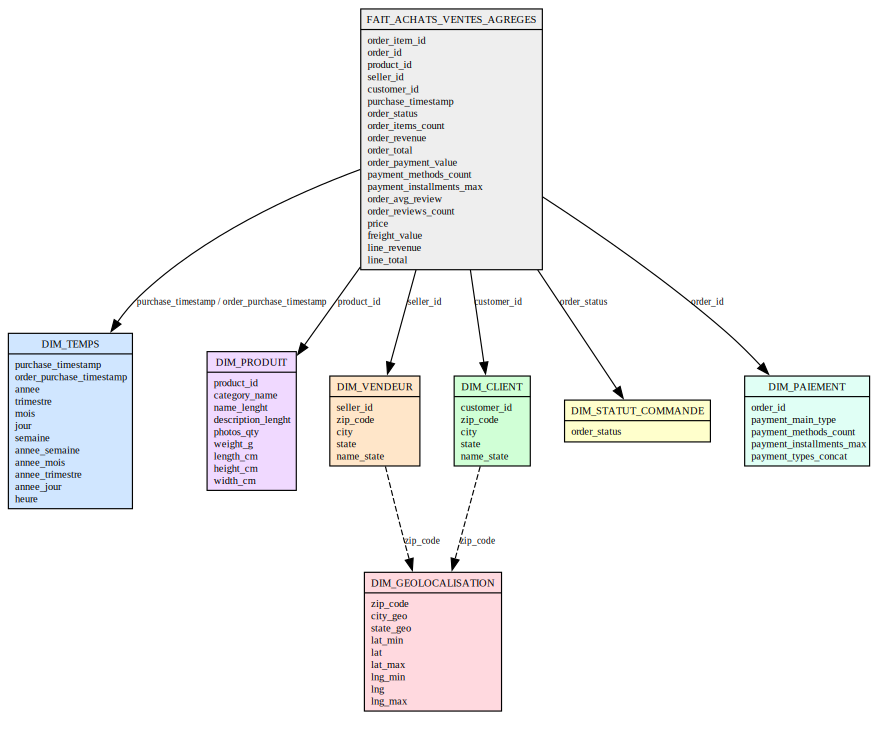

In [10]:
dot_achats = graphe_etoile_achats_ventes()
dot_achats

In [12]:
# -----------------------------------------------------------
# 1) LECTURE DES TABLES
# -----------------------------------------------------------
orders    = pd.read_parquet(DATA_PATH + "orders.parquet")
items     = pd.read_parquet(DATA_PATH + "items.parquet")
customers = pd.read_parquet(DATA_PATH + "customers.parquet")
payments  = pd.read_parquet(DATA_PATH + "payments.parquet")
reviews   = pd.read_parquet(DATA_PATH + "reviews.parquet")

print("Shapes brutes :")
print("orders   :", orders.shape)
print("items    :", items.shape)
print("customers:", customers.shape)
print("payments :", payments.shape)
print("reviews  :", reviews.shape)


# -----------------------------------------------------------
# 2) FACT DE BASE : F_ACHATS (grain = ligne d'article)
# -----------------------------------------------------------

# 2.1) Items (lignes d'achat)
items_fact = items[[
    "order_id",
    "order_item_id",
    "product_id",
    "seller_id",
    "price",
    "freight_value",
]].copy()

# 2.2) Orders (client, statut, timestamp)
# on renomme 'status' -> 'order_status' si besoin
if "status" in orders.columns and "order_status" not in orders.columns:
    orders = orders.rename(columns={"status": "order_status"})

orders_fact = orders[[
    "order_id",
    "customer_id",
    "purchase_timestamp",
    "order_status",
]].copy()

# 2.3) Customers (zip_code pour localisation)
cust_fact = customers[["customer_id", "zip_code"]].copy()

# 2.4) Jointure -> F_ACHATS
F_ACHATS = (
    items_fact
    .merge(orders_fact, on="order_id", how="left")
    .merge(cust_fact,   on="customer_id", how="left")
)

# métriques de ligne
F_ACHATS["line_revenue"] = F_ACHATS["price"]
F_ACHATS["line_total"]   = F_ACHATS["price"] + F_ACHATS["freight_value"]

print("F_ACHATS shape :", F_ACHATS.shape)


# -----------------------------------------------------------
# 3) AGRÉGATION PAR COMMANDE (ventes)
#    -> order_items_count, order_revenue, order_total
# -----------------------------------------------------------

agg_orders = (
    F_ACHATS
    .groupby("order_id", as_index=False)
    .agg(
        order_items_count=("order_item_id", "count"),
        order_revenue=("price", "sum"),
        order_total=("line_total", "sum"),
    )
)

print("agg_orders shape :", agg_orders.shape)


# -----------------------------------------------------------
# 4) AGRÉGATION DES PAIEMENTS (table brute Kaggle)
#    -> order_payment_value, payment_methods_count,
#       payment_installments_max, payment_main_type,
#       payment_types_concat
# -----------------------------------------------------------

# on enlève le préfixe "payment_" si présent
pay = payments.rename(columns=lambda c: c.replace("payment_", ""))

# agrégats simples par commande
PAY_AGG = (
    pay
    .groupby("order_id", as_index=False)
    .agg(
        order_payment_value=("value", "sum"),
        payment_methods_count=("type", "nunique"),
        payment_installments_max=("installments", "max"),
    )
)

# concaténation des types de paiement utilisés
types_concat = (
    pay
    .groupby("order_id")["type"]
    .apply(lambda x: "+".join(sorted(x.unique())))
    .reset_index(name="payment_types_concat")
)

# type principal = type avec la plus grande valeur payée
pay_type_value = (
    pay
    .groupby(["order_id", "type"], as_index=False)["value"]
    .sum()
)
idx_max = pay_type_value.groupby("order_id")["value"].idxmax()
main_type = (
    pay_type_value
    .loc[idx_max, ["order_id", "type"]]
    .rename(columns={"type": "payment_main_type"})
)

PAY_AGG = (
    PAY_AGG
    .merge(types_concat, on="order_id", how="left")
    .merge(main_type,    on="order_id", how="left")
)

print("PAY_AGG shape :", PAY_AGG.shape)
print(PAY_AGG.head(3))


# -----------------------------------------------------------
# 5) AGRÉGATION DES AVIS
#    -> order_avg_review, order_reviews_count
# -----------------------------------------------------------

rev = reviews.copy()

# colonnes score_1..5 = nb d'avis par score
score_detail_cols = [c for c in rev.columns if c.startswith("score_") and c != "score"]

rev["order_reviews_count"] = rev[score_detail_cols].sum(axis=1)
rev["order_avg_review"] = rev["score"] / rev["order_reviews_count"]
rev.loc[rev["order_reviews_count"] == 0, "order_avg_review"] = pd.NA

REV_AGG = rev[["order_id", "order_avg_review", "order_reviews_count"]].copy()

print("REV_AGG shape :", REV_AGG.shape)
print(REV_AGG.head(3))


# -----------------------------------------------------------
# 6) FACT F_ACHATS_VENTES_AGREGES
#    (grain = ligne d'article, enrichie par
#     agrégats commande + paiements + avis)
# -----------------------------------------------------------

F_ACHATS_VENTES_AGREGES = (
    F_ACHATS
    .merge(agg_orders, on="order_id", how="left")
    .merge(PAY_AGG,     on="order_id", how="left")
    .merge(REV_AGG,     on="order_id", how="left")
)

cols_fact = [
    "order_item_id",
    "order_id",
    "product_id",
    "seller_id",
    "customer_id",
    "purchase_timestamp",
    "order_status",
    "order_items_count",
    "order_revenue",
    "order_total",
    "order_payment_value",
    "payment_methods_count",
    "payment_installments_max",
    "payment_main_type",
    "payment_types_concat",
    "order_avg_review",
    "order_reviews_count",
    "price",
    "freight_value",
    "line_revenue",
    "line_total",
]

F_ACHATS_VENTES_AGREGES = F_ACHATS_VENTES_AGREGES[cols_fact]

print("F_ACHATS_VENTES_AGREGES shape :", F_ACHATS_VENTES_AGREGES.shape)
print("Colonnes (", len(F_ACHATS_VENTES_AGREGES.columns), "):")
print(list(F_ACHATS_VENTES_AGREGES.columns))
display(F_ACHATS_VENTES_AGREGES.head(5))


# -----------------------------------------------------------
# 7) SAUVEGARDE UNIQUE : FACT ACHATS + VENTES AGRÉGÉES
# -----------------------------------------------------------

OUTPUT_FACT = "f_achats_ventes_agreges.parquet"  # adapte si besoin
F_ACHATS_VENTES_AGREGES.to_parquet(OUTPUT_FACT, index=False)
print(f"F_ACHATS_VENTES_AGREGES sauvegardé dans : {OUTPUT_FACT}")


Shapes brutes :
orders   : (99441, 23)
items    : (112650, 8)
customers: (99441, 6)
payments : (103886, 5)
reviews  : (98673, 25)
F_ACHATS shape : (112650, 12)
agg_orders shape : (98666, 4)
PAY_AGG shape : (99440, 6)
REV_AGG shape : (98673, 3)
F_ACHATS_VENTES_AGREGES shape : (112650, 19)
Colonnes ( 19 ):
['order_item_id', 'order_id', 'product_id', 'seller_id', 'customer_id', 'purchase_timestamp', 'order_status', 'order_items_count', 'order_revenue', 'order_total', 'order_payment_value', 'payment_methods_count', 'payment_installments_max', 'order_avg_review', 'order_reviews_count', 'price', 'freight_value', 'line_revenue', 'line_total']
DIM_PAIEMENT shape : (99440, 5)
F_ACHATS_VENTES_AGREGES sauvegardé dans : f_achats_ventes_agreges.parquet
DIM_PAIEMENT sauvegardé dans          : dim_paiement.parquet
